In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list, sparsify_beta
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

In [3]:
import itertools
from scipy.sparse.linalg import eigsh
from scipy import optimize

In [4]:
def bound_eigenvalue(matrix, k):

    # Will need the matrix to be symmetric
    assert(np.allclose(matrix, matrix.T))
    
    t1 = time.time()
    # Sort each row
    ordering = np.argsort(np.abs(matrix), axis = 1)

    # Change to descending order
    ordering = np.fliplr(ordering)
    
    sorted_matrix = np.take_along_axis(np.abs(matrix), ordering, 1)

    # Find the diagonal and move it first    
    diagonal_locs = np.array([np.where(ordering[i, :] == i)[0][0] 
                              for i in range(ordering.shape[0])])
    for (row, column) in zip(range(ordering.shape[0]), diagonal_locs):
        sorted_matrix[row][:column+1] = np.roll(sorted_matrix[row][:column+1], 1)
        
    # Sum the first (k - 1) elements after the diagonal
    row_sums = np.sum(sorted_matrix[:, 1:k], axis = 1)
    diag = np.diagonal(matrix)
    
    # Evaluate all Bauer Cassini ovals
    pairs = list(itertools.combinations(np.arange(matrix.shape[0]), 2))
    # This takes a little bit of algebra
    oval_edges = [(np.sqrt(row_sums[idx[0]] * row_sums[idx[1]] + 1/4 * (diag[idx[0]] - diag[idx[1]])**2) \
                 + 1/2 * (row_sums[idx[1]] + row_sums[idx[0]])) for idx in pairs]
    
    # Take the max. This is a bound for any conceivable eigenvalue
    eig_bound1 = np.max(oval_edges)
    t1 = time.time() - t1
    
    return eig_bound1

In [115]:
# In contrast to bounding the eigenvalue, we explicitly fix the non-zero indices in advance, so we can just
# explicitly calculate the eigenvalue bound
def calc_eigenvalue(matrix, idxs):
    
    # Assemble the submatrix
    submatrix = matrix[np.ix_(idxs, idxs)]
    eig = eigsh(submatrix, k = 1, return_eigenvectors=False)[0]
    
    return eig

In [30]:
# Quadratic programming solver with inequality constraints
class quadprog(object):

    def __init__(self, H, f, norm, x0, lb, ub):
        self.H    = H
        self.f    = f
        self.norm = norm
        self.x0   = x0
        self.bnds = tuple([(lb, ub) for x in x0])
        # call solver
        self.result = self.solver()

    def objective_function(self, x):
        return 0.5*np.dot(np.dot(x.T, self.H), x) + np.dot(self.f.T, x)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    def solver(self):
        cons = ({'type': 'eq', 'fun': lambda x: self.norm - sum(x)})
        optimum = optimize.minimize(self.objective_function, 
                                    x0          = self.x0.T,
                                    bounds      = self.bnds,
                                    constraints = cons, 
                                    tol         = 10**-3)
        return optimum

In [44]:
def bound_irrep_const(matrix, k):

    # Heuristic worst-case subset : Set the true support to be the subspace that features the smallest sum of
    # pairwise correlations.
    
    # Check against a small sized matrix (How close do we get?)
    
    matrix = np.abs(matrix)
    p = matrix.shape[0]
    # Follows: https://stats.stackexchange.com/questions/110426/least-correlated-subset-of-random-variables-from-a-correlation-matrix
    # Use the above custom function for quadratic programming with lower/upper bounds
       
    qdprg = quadprog(matrix, np.zeros(p), k, np.random.random(p), 0, 1)
    # Take the first k largest values to get subset indices
    subset = np.argsort(qdprg.result.x)[-k:]
    
    subset_complement = np.setdiff1d(np.arange(p), subset)
    
    # Set C_11 to this subset
    C11 = matrix[np.ix_(subset, subset)]
   
    C21 = matrix[np.ix_(subset_complement, subset)]
    
    # Calculate the resulting irrep. constant
    eta = np.max(C21 @ np.linalg.inv(C11) @ np.ones(k))
    subspace_correlations = np.sum(matrix[np.ix_(subset, subset)])    
    return eta, subspace_correlations

In [120]:
def calc_irrep_const(matrix, idxs):
    
    p = matrix.shape[0]
    k = len(idxs)
    idxs_complement = np.setdiff1d(np.arange(p), idxs)
    
    C11 = matrix[np.ix_(idxs, idxs)]
    C21 = matrix[np.ix_(idxs_complement, idxs)]
    
    # Calculate the resulting irrep. constant
    eta = np.max(C21 @ np.linalg.inv(C11) @ np.ones(k))

    return eta

In [11]:
from scipy.stats import wishart, invwishart
from numpy.random import RandomState

In [7]:
from utils import gen_covariance

### Test the method for choosing an approximately "worst case" subset

In [8]:
import scipy

In [47]:
# Generate a Wishart matrix at random (20 x 20). Iterate through all subsets of size 5 and calculate the 
# irrep. constant and compare to the value we get when we use the bound_irrep_const function

p = 20
k = 5

sigma = wishart.rvs(5 * p, np.eye(p))

irrep_constants = np.zeros(int(scipy.special.binom(p, k)))
subspace_correlations = np.zeros(int(scipy.special.binom(p, k)))

for i, subset in enumerate(itertools.combinations(np.arange(p), k)):
    irrep_constants[i] = calc_irrep_const(sigma, subset)
    # Also calculate the pairwise correlations in this subspace
    subspace_correlations[i] = np.sum(sigma[np.ix_(subset, subset)])
       
irrep_const_bound, min_subspace_corr = bound_irrep_const(sigma, k)

In [49]:
np.argmax(irrep_constants)

6422

In [53]:
min(subspace_correlations)

277.31823098169116

In [50]:
np.argmin(subspace_correlations)

5924

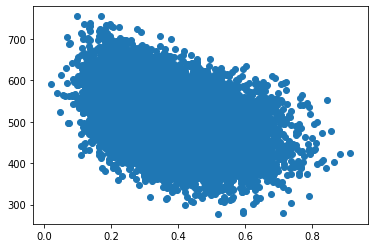

In [51]:
plt.scatter(irrep_constants, subspace_correlations)

(array([  88., 1234., 3955., 4540., 3134., 1550.,  681.,  249.,   65.,
           8.]),
 array([0.06766438, 0.16047805, 0.25329172, 0.3461054 , 0.43891907,
        0.53173274, 0.62454642, 0.71736009, 0.81017376, 0.90298743,
        0.99580111]),
 <a list of 10 Patch objects>)

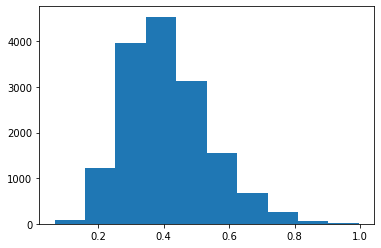

In [43]:
plt.hist(irrep_constants)

In [ ]:
# Verify the intuition that a Wishart matrix seeded with an exponential covariance matrix should be 
# approximately close to the banded structure

In [98]:
wishart_exp = wishart.rvs(500, sigma_exp)

### Generate an expanded ensemble to play with

In [123]:
# generate the standard covariance ensemble
p = 500
n = 2000
block_sizes = [25, 50, 100]
# Block correlation
correlation = [0, 0.08891397, 0.15811388, 0.28117066, 0.5]

# Exponential length scales
L = [10, 25, 50, 100]

cov_list, _ = get_cov_list(p, 60, correlation, block_sizes, L, n_supplement = 20)

cov_params = [{'correlation' : t[0], 'block_size' : t[1], 'L' : t[2], 't': t[3]} for t in cov_list]

nreps = 500

# Do not include fully dense model
sparsity = np.logspace(np.log10(0.02), 0, 15)[:-1]

rho = np.zeros((len(cov_params), nreps, sparsity.size))
eta = np.zeros((len(cov_params), nreps, sparsity.size))        

for i1, cov_param in enumerate(cov_params):
    
    t0 = time.time()
    
    # Generate 500 Wishart matrices seeded by this particular sigma
    sigma = gen_covariance(p, **cov_param)
    
    for rep in range(nreps):
        # Generate a random seed uniquely corresponding to combination of i1 and rep:
        # Utilizes the Cantor pairing function
        rand_seed = int(1/2 * (i1 + rep) * (i1 + rep + 1) + rep)
        random_state = RandomState(rand_seed)
            
        sigma_rep = wishart.rvs(df=n, scale=sigma, random_state=random_state)
        
        for i3, s in enumerate(sparsity):
            # Keep the nonzero components of beta fixed for each sparsity
            # Here, we ensure that blocks are treated equally
            
            subset = sparsify_beta(np.ones((p, 1), dtype=int), block_size=cov_param['block_size'], 
                                   sparsity = s, seed = s).ravel()

            if len(np.nonzero(subset)[0]) == 0:
                rho[i1, rep, i3] = np.nan
                eta[i1, rep, i3] = np.nan
                continue
                
            else:
                                
                rho_ = 1/calc_eigenvalue(np.linalg.inv(sigma_rep), np.nonzero(subset)[0])
                rho[i1, rep, i3] = rho_ 

                eta[i1, rep, i3] = calc_irrep_const(sigma_rep, np.nonzero(subset)[0])
                
    print(time.time() - t0)
    
    print('%d/%d' % (i1 + 1, len(cov_params)))
    

63.60861587524414
1/80
59.49524641036987
2/80
54.26375865936279
3/80
49.9421751499176
4/80
56.537397146224976
5/80
54.58986687660217
6/80
51.74505090713501
7/80
56.19660544395447
8/80
55.38501739501953
9/80
50.9654438495636
10/80
57.250025510787964
11/80
54.831095933914185
12/80
50.47407126426697
13/80
55.8282527923584
14/80
55.50596070289612
15/80
53.0787239074707
16/80
55.943060874938965
17/80
55.019898891448975
18/80
54.91848683357239
19/80
49.79276084899902
20/80
50.59603762626648
21/80
56.88428735733032
22/80
55.63915491104126
23/80
56.60812997817993
24/80
56.98773241043091
25/80
52.438987255096436
26/80
50.830336809158325
27/80
56.56634545326233
28/80
55.704989433288574
29/80
52.32727074623108
30/80
50.75086259841919
31/80
55.49715542793274
32/80
60.97416949272156
33/80
54.456918716430664
34/80
57.10381865501404
35/80
55.667457580566406
36/80
57.0866801738739
37/80
55.77369689941406
38/80
51.23842406272888
39/80
57.482139587402344
40/80
56.30531311035156
41/80
50.640626192092896


/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 89271., 107974.,  93887.,  79167.,  53218.,  37953.,  30887.,
         16603.,   9605.,   2435.]),
 array([   4.26713925,  144.95504817,  285.6429571 ,  426.33086603,
         567.01877495,  707.70668388,  848.39459281,  989.08250173,
        1129.77041066, 1270.45831959, 1411.14622851]),
 <a list of 10 Patch objects>)

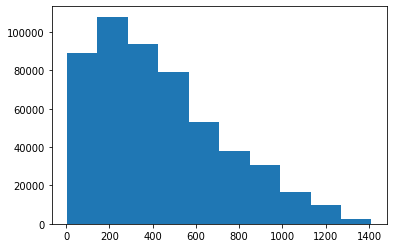

In [125]:
plt.hist(rho.ravel())

(array([8.94600e+03, 1.82910e+04, 3.44450e+04, 6.66320e+04, 3.47759e+05,
        4.21850e+04, 2.57500e+03, 1.44000e+02, 2.00000e+01, 3.00000e+00]),
 array([0.15389018, 0.36058903, 0.56728788, 0.77398673, 0.98068558,
        1.18738443, 1.39408328, 1.60078213, 1.80748098, 2.01417983,
        2.22087868]),
 <a list of 10 Patch objects>)

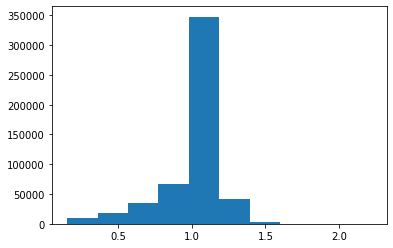

In [126]:
plt.hist(eta.ravel())